# Classification: blind SQL injection vulnerability detection

In this notebook, I consider the problem of blind SQL injection vulnerability detection using the method of Classification. Specifically, given the round-trip-time (RTT) of a URL that was asked to go to sleep for a few seconds, the goal is to predict if the url is vulnerable to a blind SQL injection (label 1) or is safe (label 0).

**Dataset**

The training and test data sets for this problem is provided in the file `dataset_50000_2.csv`. Each row in these files corresponds to a url, with column 2 containing the sleep delay injected and column 3 containing the RTT. The last column contains the class label, and is based on the label of url, safe or vulnerable.

The dataset contains a total of 100,000 urls, of which the first half are vulnerable, while the remaining are all safe. 

**Optimization**

The goal is optimize the Classification algorithm for speed and specificity. More speficically, it needs to test a single url within a few seconds and to have a FPR of less than 0.0001 (1 in 10,000)

Import libraries

In [118]:
import numpy as np
import statsmodels as sm
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from statsmodels.distributions.empirical_distribution import ECDF
import sklearn.metrics as metrics
import pickle
import timeit
import seaborn as sns
import svc_test as svc
import requests
sns.set()

# Part (a): Data Exploration

1. Collect RTTS of safe and vulnerable URLs and save them into CSV files.

2. Compare the safe and vulnerable RTTs by visualizing them and comparing their mean (as well as other metrics).

**Note:** In order to collect thousands of RTTs in a reasonable amount of time, I wrote a script that makes http requests asynchronously. This script can only run outside of this jupyter notebook

In [119]:
# 50,000 RTTs, half vulnerable and hald safe with a 2 second sleep delay
dataset_df = pd.read_csv('Other/dataset_50000_2.csv')

In [120]:
dataset_df.head()

,URL,Sleep Delay,RTT,Vulnerable
0,http://localhost:5000/vulnerable/1/page?id=SLE...,2,14.356463,1
1,http://localhost:5000/vulnerable/2/page?id=SLE...,2,11.794838,1
2,http://localhost:5000/vulnerable/3/page?id=SLE...,2,15.530525,1
3,http://localhost:5000/vulnerable/4/page?id=SLE...,2,15.984062,1
4,http://localhost:5000/vulnerable/5/page?id=SLE...,2,12.523224,1


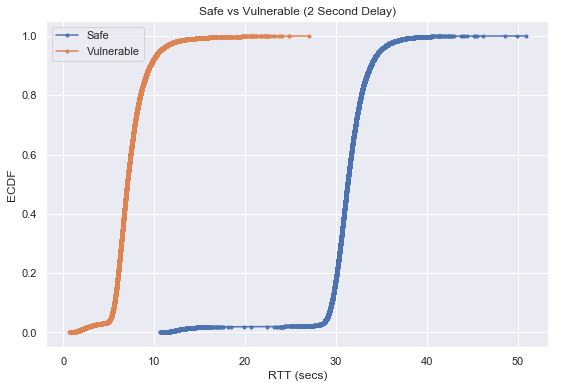

In [121]:
# Splits the data into Vulnerable and Safe urls
vul_data = dataset_df[dataset_df['Vulnerable']==1]
safe_data = dataset_df[dataset_df['Vulnerable']==0]

# Calculates CDFs
vul_ecdf = ECDF(vul_data['RTT']) 
safe_ecdf = ECDF(safe_data['RTT'])

plt.figure(figsize=(9, 6))

_ = plt.plot(vul_ecdf.x, vul_ecdf.y, marker='.')
_ = plt.plot(safe_ecdf.x, safe_ecdf.y, marker='.')
_ = plt.title('Safe vs Vulnerable (2 Second Delay)')
_ = plt.legend(('Safe', 'Vulnerable'), loc='best')
_ = plt.xlabel('RTT (secs)')
_ = plt.ylabel('ECDF')

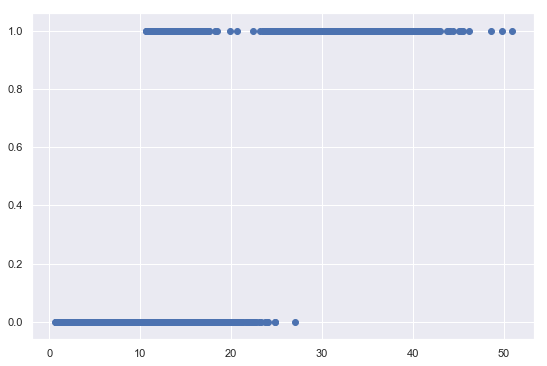

In [122]:
plt.figure(figsize=(9, 6))
_ = plt.scatter(dataset_df['RTT'], dataset_df['Vulnerable'])

**Observations:** The plot shows that most of the RTTs for both the safe and vulnerable URLs are much larger than expected. After doing much investigation, I noticed that the inflated RTTs were due to making http requests asynchronously. For the time being, I will use the data as is to train the classifier and attempt to find an alternative to the my current data collection method later.

## Part (b): Training the Classifier

After trying out different classifier, Logistic Regression, Decision Tree, etc.., I decided to use a Support Vector Classifier as it seemed to give me the best score

In [123]:
x_train, x_test, y_train, y_test = train_test_split(dataset_df['RTT'], dataset_df['Vulnerable'], test_size=0.41, random_state=0)

In [124]:
# Train the model
svc_model = SVC(C=10, gamma='auto', kernel = 'rbf', probability=True)
svc_model.fit(np.array(x_train).reshape(-1,1), y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Part (c): Evaluating and Optimizing

1. Evaluating the model using the test data
2. Making predictions with new data

**1. Evaluating the model using the test data**

In [125]:
# Make prediction on test data
y_predict = svc_model.predict(np.array(x_test).reshape(-1,1))

In [126]:
print('The Accuracy score is: {}'.format(accuracy_score(y_test, y_predict)))

The Accuracy score is: 0.9903414634146341


In [127]:
print('Confusion Matrix')
print(confusion_matrix(y_test, y_predict))

Confusion Matrix
[[10254     3]
 [  195 10048]]


In [128]:
tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
print('The FPR is: {}'.format(fp/(fp+tn)))
print('The FNR is {}'.format(fn/(fn+tp)))

The FPR is: 0.0002924831822170225
The FNR is 0.01903739138924143


In [129]:
# Save the trained model for later use
filename = 'svc_final_model.pickle'
#pickle.dump(svc_model, open(filename, 'wb'))

**2. Making predictions with new data**

In [135]:
def test(url):
    '''
    Returns whether the url passed is vulnerable (label 1) or safe (label 0)
    '''
    
    # Load the trained SVC Model
    svc_model = pickle.load(open('svc_final_model.pickle', 'rb'))

    sleep_delay = 2 # The same sleep delay used during the training of the model
    start = timeit.default_timer()
    resp = requests.get(url + 'SLEEP({})'.format(sleep_delay))
    rtt = np.array(timeit.default_timer() - start).reshape(-1,1)
    
    return svc_model.predict(rtt)[0]

**Note:** The above code could also be found inside `svc_test.py`

In [136]:
# Making predictions on 10 unseen vulnerable URLs. 
for i in range(11):
    url = 'http://localhost:5000/vulnerable/{}/page?id='.format(i)
    print(test(url))

0
0
0
0
0
0
0
0
0
0
0


**Observations:** Although the FPR for this model was promising, I encountered an issued while making predictions on new data (not the test data). Even though the confusion matrix reported a FNR of 0.01 (that is 1 in 100), as you can see above, the model mislabeled all 10 vulnerable (label 1) urls as safe (label 0). This was unfortunately due to the inflated RTTs that it was trained on. Since the RTT (not inflated) for a vulnerable url with a sleep delay of 2 seconds ranges from about 11-15 seconds, and the SVC expects it be larger than ~25 seconds, it get labeled as safe. 

This issue could be resolved by improving the way the elapsed time of the asynchronous http requests is measured during the collection of the training data.